In [1]:
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet121, InceptionV3, MobileNetV2, InceptionResNetV2
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import seaborn as sns

In [4]:
# Check GPU availability
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = "/content/drive/MyDrive/RCP-CNN-1/CoLeaf-augmented"

In [6]:
train_dir= '/content/drive/MyDrive/RCP-CNN-1/CoLeaf-augmented/train'
val_dir= '/content/drive/MyDrive/RCP-CNN-1/CoLeaf-augmented/eval'
test_dir= '/content/drive/MyDrive/RCP-CNN-1/CoLeaf-augmented/test'

In [7]:
# Define image size and batch size
img_size = (224, 224)  # Example image size, adjust as needed
batch_size = 32  # Example batch size, adjust as needed

In [8]:
# Data generators
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest'
                                   )

val_test_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
# Cargar los datasets usando tf.data
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=False
)

# Capture class names before transforming datasets
class_names = train_dataset.class_names

Found 17301 files belonging to 10 classes.
Found 3708 files belonging to 10 classes.
Found 3712 files belonging to 10 classes.


In [10]:
# Función de aumento de datos
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, label

In [11]:
# Aplicar aumentos y optimizaciones al pipeline
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.map(augment, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(buffer_size=1000)
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

val_dataset = val_dataset.cache()
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

test_dataset = test_dataset.cache()
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


In [12]:
def build_model(base_model):
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.Dropout(0.5)(x)  # 50% Dropout
    predictions = layers.Dense(len(class_names), activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [13]:
def build_and_train_model(base_model, model_name):
    for layer in base_model.layers:
        layer.trainable = False  # Freeze all layers in the base model

    model = build_model(base_model)

    # Learning rate schedule
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=100000,
        decay_rate=0.96,
        staircase=True
    )

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=50
        #callbacks=[early_stopping]
    )

    return model, history

In [14]:
def plot_history(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(10, 8))
    plt.subplot(2, 1, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{model_name} Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{model_name} Training and Validation Loss')

    plt.show()

In [15]:
# Fine-tuning function
def fine_tune_model(model, base_model, fine_tune_at=100):
    # Unfreeze the base model from the specified layer onward
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
    for layer in base_model.layers[fine_tune_at:]:
        layer.trainable = True

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history_fine = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=10  # Fine-tune for an additional 10 epochs
    )

    return history_fine

In [16]:
# Function to train ResNet50
def train_resnet50():
    # Initialize ResNet50 base model
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers:
        layer.trainable = False  # Freeze the base model layers

    # Build and train the model using ResNet50 as the base
    model, history = build_and_train_model(base_model, 'ResNet50')

    # Plot the training history
    plot_history(history, 'ResNet50')

    return model, base_model  # Return the model and the base model for further fine-tuning or evaluation

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 2142s 785ms/step - accuracy: 0.8113 - loss: 2.2471 - val_accuracy: 0.8897 - val_loss: 1.4788
Epoch 2/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 51s 95ms/step - accuracy: 0.8988 - loss: 1.3197 - val_accuracy: 0.8886 - val_loss: 1.1122
Epoch 3/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 52s 97ms/step - accuracy: 0.9007 - loss: 1.0305 - val_accuracy: 0.8964 - val_loss: 0.9488
Epoch 4/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 53s 97ms/step - accuracy: 0.9017 - loss: 0.8948 - val_accuracy: 0.8857 - val_loss: 0.9342
Epoch 5/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 53s 97ms/step - accuracy: 0.9062 - loss: 0.8474 - val_accuracy: 0.8972 - val_loss: 0.8906
Epoch 6/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 53s 98ms/step - accuracy: 0.9039 - loss: 0.8509 - val_accuracy: 0.8975 - val_loss: 0.9073
Epoch 7/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 53s 98ms/step - accuracy: 0.9040 - loss: 0.8451 - val_accuracy: 0.9075 - val_loss: 0.7847
Epoch 8/50
541/541 ━━━━━━━━━━━━━━━━━

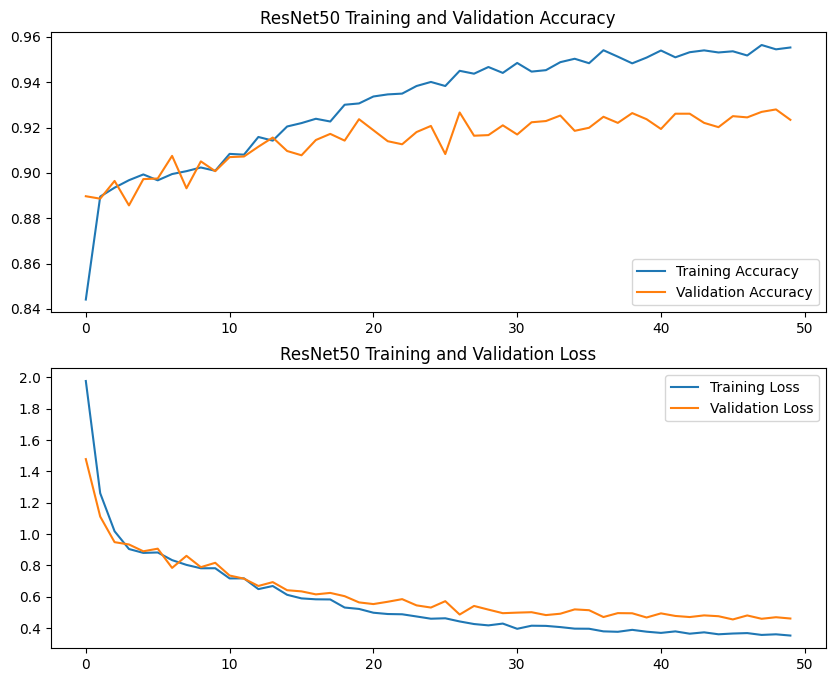

Epoch 1/10
541/541 ━━━━━━━━━━━━━━━━━━━━ 139s 201ms/step - accuracy: 0.8769 - loss: 0.6447 - val_accuracy: 0.9302 - val_loss: 0.4581
Epoch 2/10
541/541 ━━━━━━━━━━━━━━━━━━━━ 91s 169ms/step - accuracy: 0.9594 - loss: 0.3418 - val_accuracy: 0.9299 - val_loss: 0.4471
Epoch 3/10
541/541 ━━━━━━━━━━━━━━━━━━━━ 92s 170ms/step - accuracy: 0.9793 - loss: 0.2851 - val_accuracy: 0.9350 - val_loss: 0.4389
Epoch 4/10
541/541 ━━━━━━━━━━━━━━━━━━━━ 92s 170ms/step - accuracy: 0.9889 - loss: 0.2576 - val_accuracy: 0.9377 - val_loss: 0.4337
Epoch 5/10
541/541 ━━━━━━━━━━━━━━━━━━━━ 92s 170ms/step - accuracy: 0.9948 - loss: 0.2407 - val_accuracy: 0.9358 - val_loss: 0.4399
Epoch 6/10
541/541 ━━━━━━━━━━━━━━━━━━━━ 92s 171ms/step - accuracy: 0.9966 - loss: 0.2338 - val_accuracy: 0.9369 - val_loss: 0.4426
Epoch 7/10
541/541 ━━━━━━━━━━━━━━━━━━━━ 92s 171ms/step - accuracy: 0.9964 - loss: 0.2265 - val_accuracy: 0.9409 - val_loss: 0.4431
Epoch 8/10
541/541 ━━━━━━━━━━━━━━━━━━━━ 92s 171ms/step - accuracy: 0.9980 - loss: 

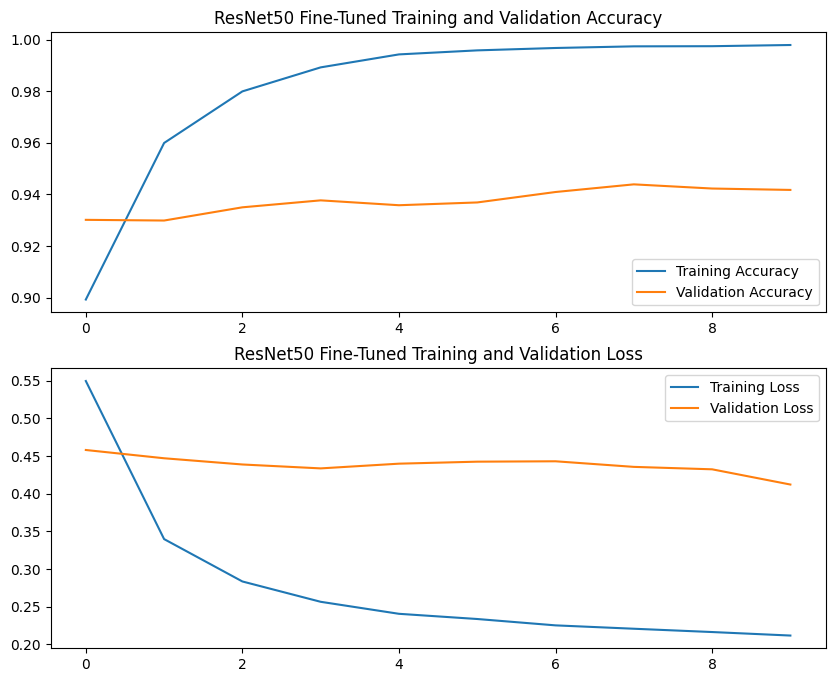

In [17]:
# Train the ResNet50 model
resnet50_model, resnet50_base_model = train_resnet50()

# Fine-tune the ResNet50 model
history_fine = fine_tune_model(resnet50_model, resnet50_base_model, fine_tune_at=100)  # Fine-tune from layer 100 onward
plot_history(history_fine, 'ResNet50 Fine-Tuned')

## Evaluation

In [18]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = resnet50_model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

116/116 ━━━━━━━━━━━━━━━━━━━━ 370s 3s/step - accuracy: 0.9541 - loss: 0.3735
Test Accuracy: 94.23%
Test Loss: 0.4246


In [19]:
predictions = resnet50_model.predict(test_dataset)

116/116 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step


In [20]:
# Convert predictions to class labels
predicted_classes = tf.argmax(predictions, axis=1)
true_classes = tf.concat([y for x, y in test_dataset], axis=0)
true_classes = tf.argmax(true_classes, axis=1)

### Metrics of evaluation based on confusion matrix

In [21]:
# Display classification report
from sklearn.metrics import classification_report
print(classification_report(true_classes, predicted_classes, target_names=class_names))

              precision    recall  f1-score   support

       boron       0.96      0.97      0.97       401
     calcium       0.93      0.95      0.94       374
     healthy       0.99      0.98      0.99       382
        iron       0.92      0.97      0.94       365
   magnesium       0.91      0.90      0.90       372
   manganese       0.94      0.90      0.92       363
    nitrogen       0.95      0.94      0.95       354
      others       0.87      0.90      0.88       362
  phosphorus       0.97      0.96      0.97       367
    potasium       0.98      0.94      0.96       372

    accuracy                           0.94      3712
   macro avg       0.94      0.94      0.94      3712
weighted avg       0.94      0.94      0.94      3712



### Confusion Matrix

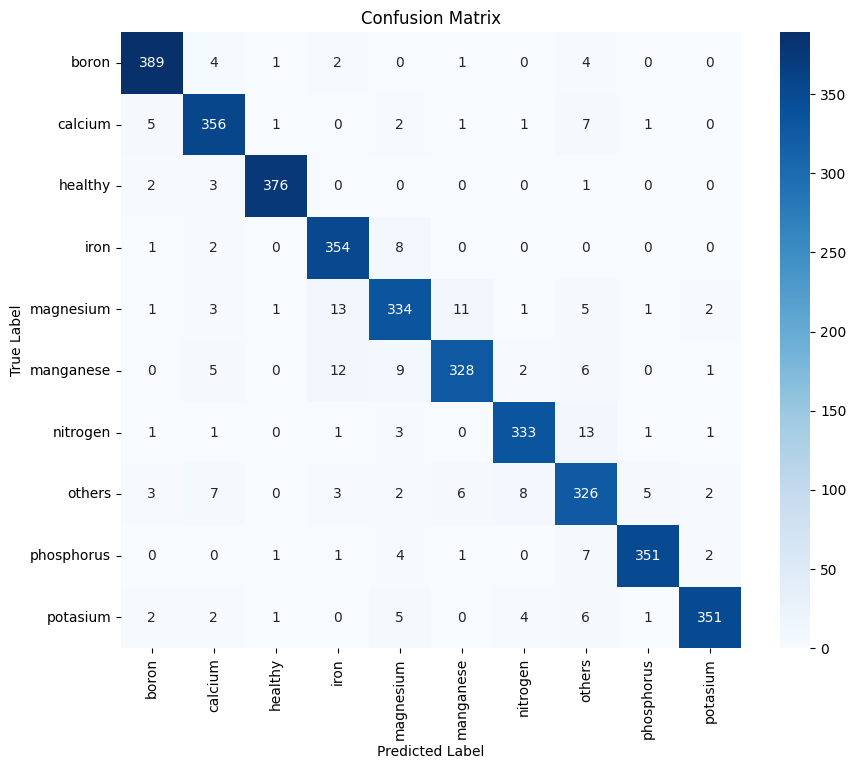

In [22]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute and plot confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()